In [1]:
import numpy as np
import ellc
import matplotlib.pyplot as plt
import lightkurve as lk

In [2]:
plt.rcParams['figure.dpi'] = 200

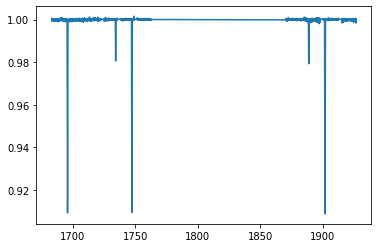

In [8]:
%matplotlib inline
t, y, yerr = np.loadtxt('../../data/photometry/tess_corrected.txt', usecols=(0,1,2)).T
t0_guess = t[np.argmin(y)]

plt.plot(t,y)

In [9]:
# t0_guess = t[np.argmin(y)]

# spacing = 0.4

# y_transit = y[(t > t0_guess-spacing) & (t < t0_guess+spacing)]
# t_transit = t[(t > t0_guess-spacing) & (t < t0_guess+spacing)]
# yerr_transit = yerr[(t > t0_guess-spacing) & (t < t0_guess+spacing)]

# plt.plot(t_transit, y_transit, '.k')
# plt.xlabel('Time')
# plt.ylabel('Flux')

# t1_guess = t[t>1700][np.argmin(y[t>1700])]
# y_transit2 = y[(t > t1_guess-spacing) & (t < t1_guess+spacing)]
# t_transit2 = t[(t > t1_guess-spacing) & (t < t1_guess+spacing)]
# yerr_transit2 = yerr[(t > t1_guess-spacing) & (t < t1_guess+spacing)]

# t2_guess = t[(t>1700) & (t<1740)][np.argmin(y[(t>1700) & (t<1740)])]
# y_transit3 = y[(t > t2_guess-spacing) & (t < t2_guess+spacing)]
# t_transit3 = t[(t > t2_guess-spacing) & (t < t2_guess+spacing)]
# yerr_transit3 = yerr[(t > t2_guess-spacing) & (t < t2_guess+spacing)]

# y_transit /= np.max(y_transit)
# y_transit2 /= np.max(y_transit2)
# y_transit3 /= np.max(y_transit3)

In [10]:
time, flux, flux_err = t, y, yerr
time += 2457000

lit_period = 51.4213

# Estimate t0s
m = time < 2458700
lit_t0 = time[m][np.argmin(flux[m])]
t0_guess = lit_t0
m = (time > lit_t0 + 1.) & (time < 2458740)
lit_t1 = time[m][np.argmin(flux[m])]

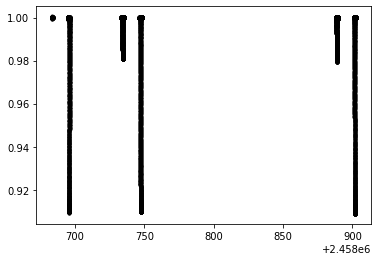

In [11]:
edge = 0.9
m = (
    (time < (lit_t0 + edge)) & (time > (lit_t0 - edge)) |
    (time < (lit_t1 + edge)) & (time > (lit_t1 - edge))
)
for i in range(-100, 100):
    m = m | (
        (time < (lit_t0 + lit_period * i + edge)) & (time > (lit_t0 + lit_period * i - edge)) |
        (time < (lit_t1 + lit_period * i + edge)) & (time > (lit_t1 + lit_period * i - edge))
    )
plt.plot(time[m], flux[m], '.k')
time, flux, flux_err = time[m][::], flux[m][::], flux_err[m][::]


In [12]:
# full_transit_time, full_transit_flux, full_transit_err = np.hstack([t_transit, t_transit2, t_transit3]), np.hstack([y_transit, y_transit2, y_transit3]), np.hstack([yerr_transit, yerr_transit2, yerr_transit3])
full_transit_time, full_transit_flux, full_transit_err = time, flux, flux_err
sort = np.argsort(full_transit_time)
full_transit_time = full_transit_time[sort][::20]
full_transit_flux = full_transit_flux[sort][::20]
full_transit_err = full_transit_err[sort][::20]

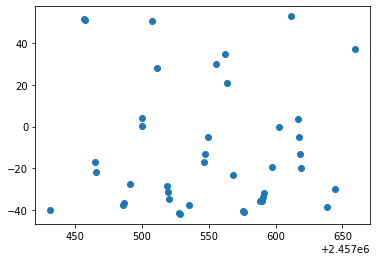

In [22]:
rv_time, rv_rv, rv_err = np.loadtxt('../../data/RV/bischoff_rv_fixed_time.txt', usecols=(0,1,2)).T
rv_time += 2457000
plt.scatter(rv_time, rv_rv)

In [23]:
def q_to_u(q1, q2):
    return 2*np.sqrt(q1)*q2, np.sqrt(q1)*(1 - 2*q2)

def lc_model(params, x):
    period, rsum, rratio, incl, sbratio, t0, f_c, f_s, sma, gammav, q11, q12, q21, q22, domdt, loglc, logrv = params
    r1, r2 = rsum/(1.+rratio), rsum*rratio/(1.+rratio)
    
    u11, u12 = q_to_u(q11,q12)
    u21, u22 = q_to_u(q21,q22)
    
    lc = ellc.lc(x,t_zero=t0,
                radius_1=r1, radius_2=r2,
                incl=incl,
                sbratio=sbratio, shape_1='sphere', shape_2='sphere',
                period=period, f_c=f_c, f_s=f_s,
                 # Limb darkening
                ld_1='quad', ld_2='quad', ldc_1=[u11, u12], ldc_2=[u21,u22],
                a=sma,
                domdt=domdt,)
    return lc# + mean

def rv_model(params, x):
    period, rsum, rratio, incl, sbratio, t0, f_c, f_s, sma, gammav, q11, q12, q21, q22, domdt, loglc, logrv = params
    r1, r2 = rsum/(1.+rratio), rsum*rratio/(1.+rratio)
    u11, u12 = q_to_u(q11,q12)
    u21, u22 = q_to_u(q21,q22)
    rv = ellc.rv(x,t_zero=t0,
                radius_1=r1, radius_2=r2,
                incl=incl,
                sbratio=sbratio, shape_1='sphere', shape_2='sphere',
                period=period, f_c=f_c, f_s=f_s,
                 # Limb darkening
                ld_1='quad', ld_2='quad', ldc_1=[u11, u12], ldc_2=[u21,u22],
                a=sma,
                domdt=domdt,)
    return rv[0] + gammav

def lnprior(params):
    period, rsum, rratio, incl, sbratio, t0, f_c, f_s, sma, gammav, q11, q12, q21, q22, domdt, loglc, logrv = params
    r1, r2 = rsum/(1.+rratio), rsum*rratio/(1.+rratio)
    if (0 < q11 < 1) & (0 < q12 < 1) & (0 < q21 < 1) & (0 < q22 < 1) & (70 < incl < 90) & (sbratio < 1.5) & ((t0_guess-1) < t0 < (t0_guess+1)):
        return 0.
    else:
        return -np.inf

def lnlike(params, x, y, yerr, x_rv, y_rv, yerr_rv):
    period, rsum, rratio, incl, sbratio, t0, f_c, f_s, sma, gammav, q11, q12, q21, q22, domdt, loglc, logrv = params
    lp = lnprior(params)
    if not np.isfinite(lp):
        return -np.inf
    # LC
    model_flux = lc_model(params, x)
    sigma2 = yerr ** 2+ model_flux ** 2 * np.exp(2 * loglc)
    ln_lc = -0.5*np.sum((y-model_flux)**2/sigma2 + np.log(sigma2))

    # RV
    model_rv = rv_model(params, x_rv)
    sigma2 = yerr_rv ** 2 + model_rv ** 2 * np.exp(2 * logrv)
    ln_rv = -0.5*np.sum((y_rv-model_rv)**2/sigma2 + np.log(sigma2))

    return ln_lc + ln_rv
    
from scipy.optimize import minimize
nll = lambda *args: -lnlike(*args)

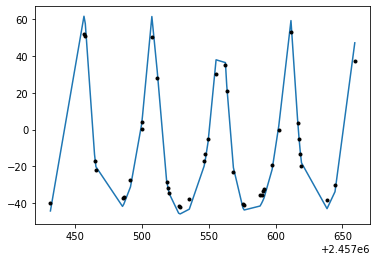

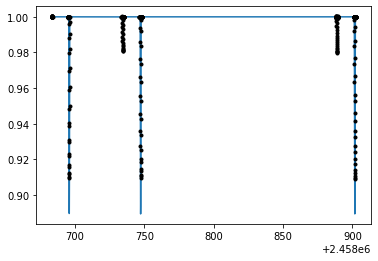

In [24]:
params = np.array([
    5.14192040e+01, # Period
    7.17949071e-02, # Rsum
    6.28722905e-01, # Rratio
    8.62150418e+01, # Incl
    0.1, # Sbratio
    lit_t0, # t0
    6.20730605e-01, # fc
    1.60481296e-01, # fs
#     0., #logf
#     0., #mean
    100, #sma
    -13.53, #gammav
    2.68060970e-01, # q11
    4.55712020e-01, # q12
    8.30538026e-01, # q21
    5.82431661e-02, # q22
    0., #domdt
    0., #loglc
    0., #logrv
])

a = rv_model(params, rv_time)
plt.plot(rv_time, a)
plt.plot(rv_time, rv_rv, '.k')
plt.show()

b = lc_model(params, full_transit_time)
plt.plot(full_transit_time, b)
plt.plot(full_transit_time, full_transit_flux, '.k')
plt.show()

In [25]:
f_c, f_s = 0.6071025773236461, 0.24107770657401392, 

bounds = [
    (50,52), #period
    (0.01, 0.1), # rsum
    (0.1, 0.9), #rratio
    (80, 90), #incl
    (0.1, 0.5),#sbratio
    (t0_guess-1, t0_guess+1), #t0
    (f_c-0.1, f_c+0.1), #fc
    (f_s-0.1, f_s+0.1),#ds
#     (-10,10),#mean
    (10,150), #sma
    (-20,-5),#gammav
    (0,1),
    (0,1),
    (0,1),
    (0,1),
    (-1,1),#domdt 
    (-10,10),#mean
    (-10,10),#mean
]

params = np.array([
    5.14192040e+01, # Period
    7.17949071e-02, # Rsum
    6.28722905e-01, # Rratio
    8.62150418e+01, # Incl
    6.91829286e-01, # Sbratio
    lit_t0, # t0
    6.20730605e-01, # fc
    1.60481296e-01, # fs
#     0., #logf
#     0., #mean
    100, #sma
    -13.53, #gammav
    2.68060970e-01, # q11
    4.55712020e-01, # q12
    8.30538026e-01, # q21
    5.82431661e-02, # q22
    0., #domdt
    0.,
    0.,
])

In [26]:
from scipy.optimize import differential_evolution

soln = differential_evolution(nll, bounds, args=(full_transit_time, full_transit_flux, full_transit_err,
      rv_time, rv_rv, rv_err))

/home/daniel/anaconda3/envs/ellc/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [28]:
soln

     fun: -2421.495431867124
 message: 'Optimization terminated successfully.'
    nfev: 225219
     nit: 882
 success: True
       x: array([ 5.14235827e+01,  6.64915009e-02,  4.26228364e-01,  8.67505456e+01,
        4.98800306e-01,  2.45869602e+06,  6.21868941e-01,  1.53963797e-01,
        8.52325602e+01, -1.34566347e+01,  1.24540192e-01,  7.25663791e-01,
        9.82530219e-01,  9.89037278e-01,  4.98244721e-02, -8.09342062e+00,
       -2.40807642e+00])

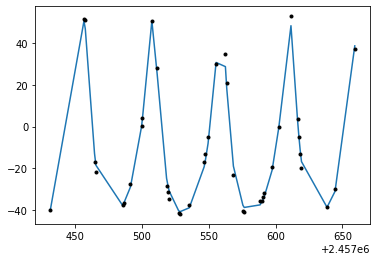

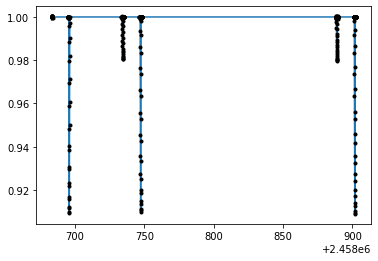

In [29]:
params = soln.x
a = rv_model(params, rv_time)
plt.plot(rv_time, a)
plt.plot(rv_time, rv_rv, '.k')
plt.show()

b = lc_model(params, full_transit_time)
plt.plot(full_transit_time, b)
plt.plot(full_transit_time, full_transit_flux, '.k')
plt.show()

In [30]:
soln

     fun: -2421.495431867124
 message: 'Optimization terminated successfully.'
    nfev: 225219
     nit: 882
 success: True
       x: array([ 5.14235827e+01,  6.64915009e-02,  4.26228364e-01,  8.67505456e+01,
        4.98800306e-01,  2.45869602e+06,  6.21868941e-01,  1.53963797e-01,
        8.52325602e+01, -1.34566347e+01,  1.24540192e-01,  7.25663791e-01,
        9.82530219e-01,  9.89037278e-01,  4.98244721e-02, -8.09342062e+00,
       -2.40807642e+00])

In [31]:
import emcee

pos = soln.x + 1e-4*np.random.randn(100, len(soln.x))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(full_transit_time, full_transit_flux, full_transit_err,
      rv_time, rv_rv, rv_err))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [2:06:38<00:00,  1.52s/it]


In [33]:
discard = 2500
flat_samples = sampler.get_chain(discard=discard,)

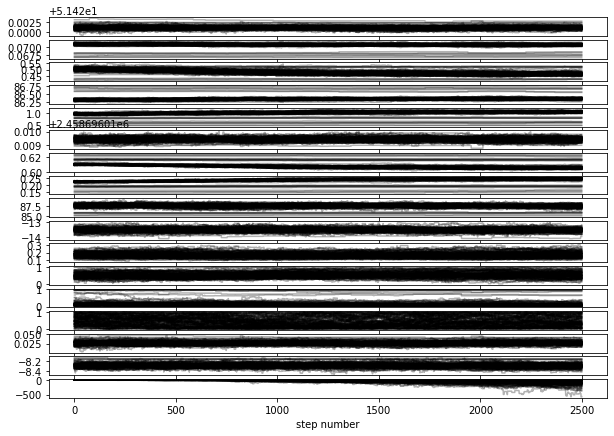

In [34]:
fig, axes = plt.subplots(len(flat_samples.T), figsize=(10, 7), sharex=True)
# samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(flat_samples[:, :, i], "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

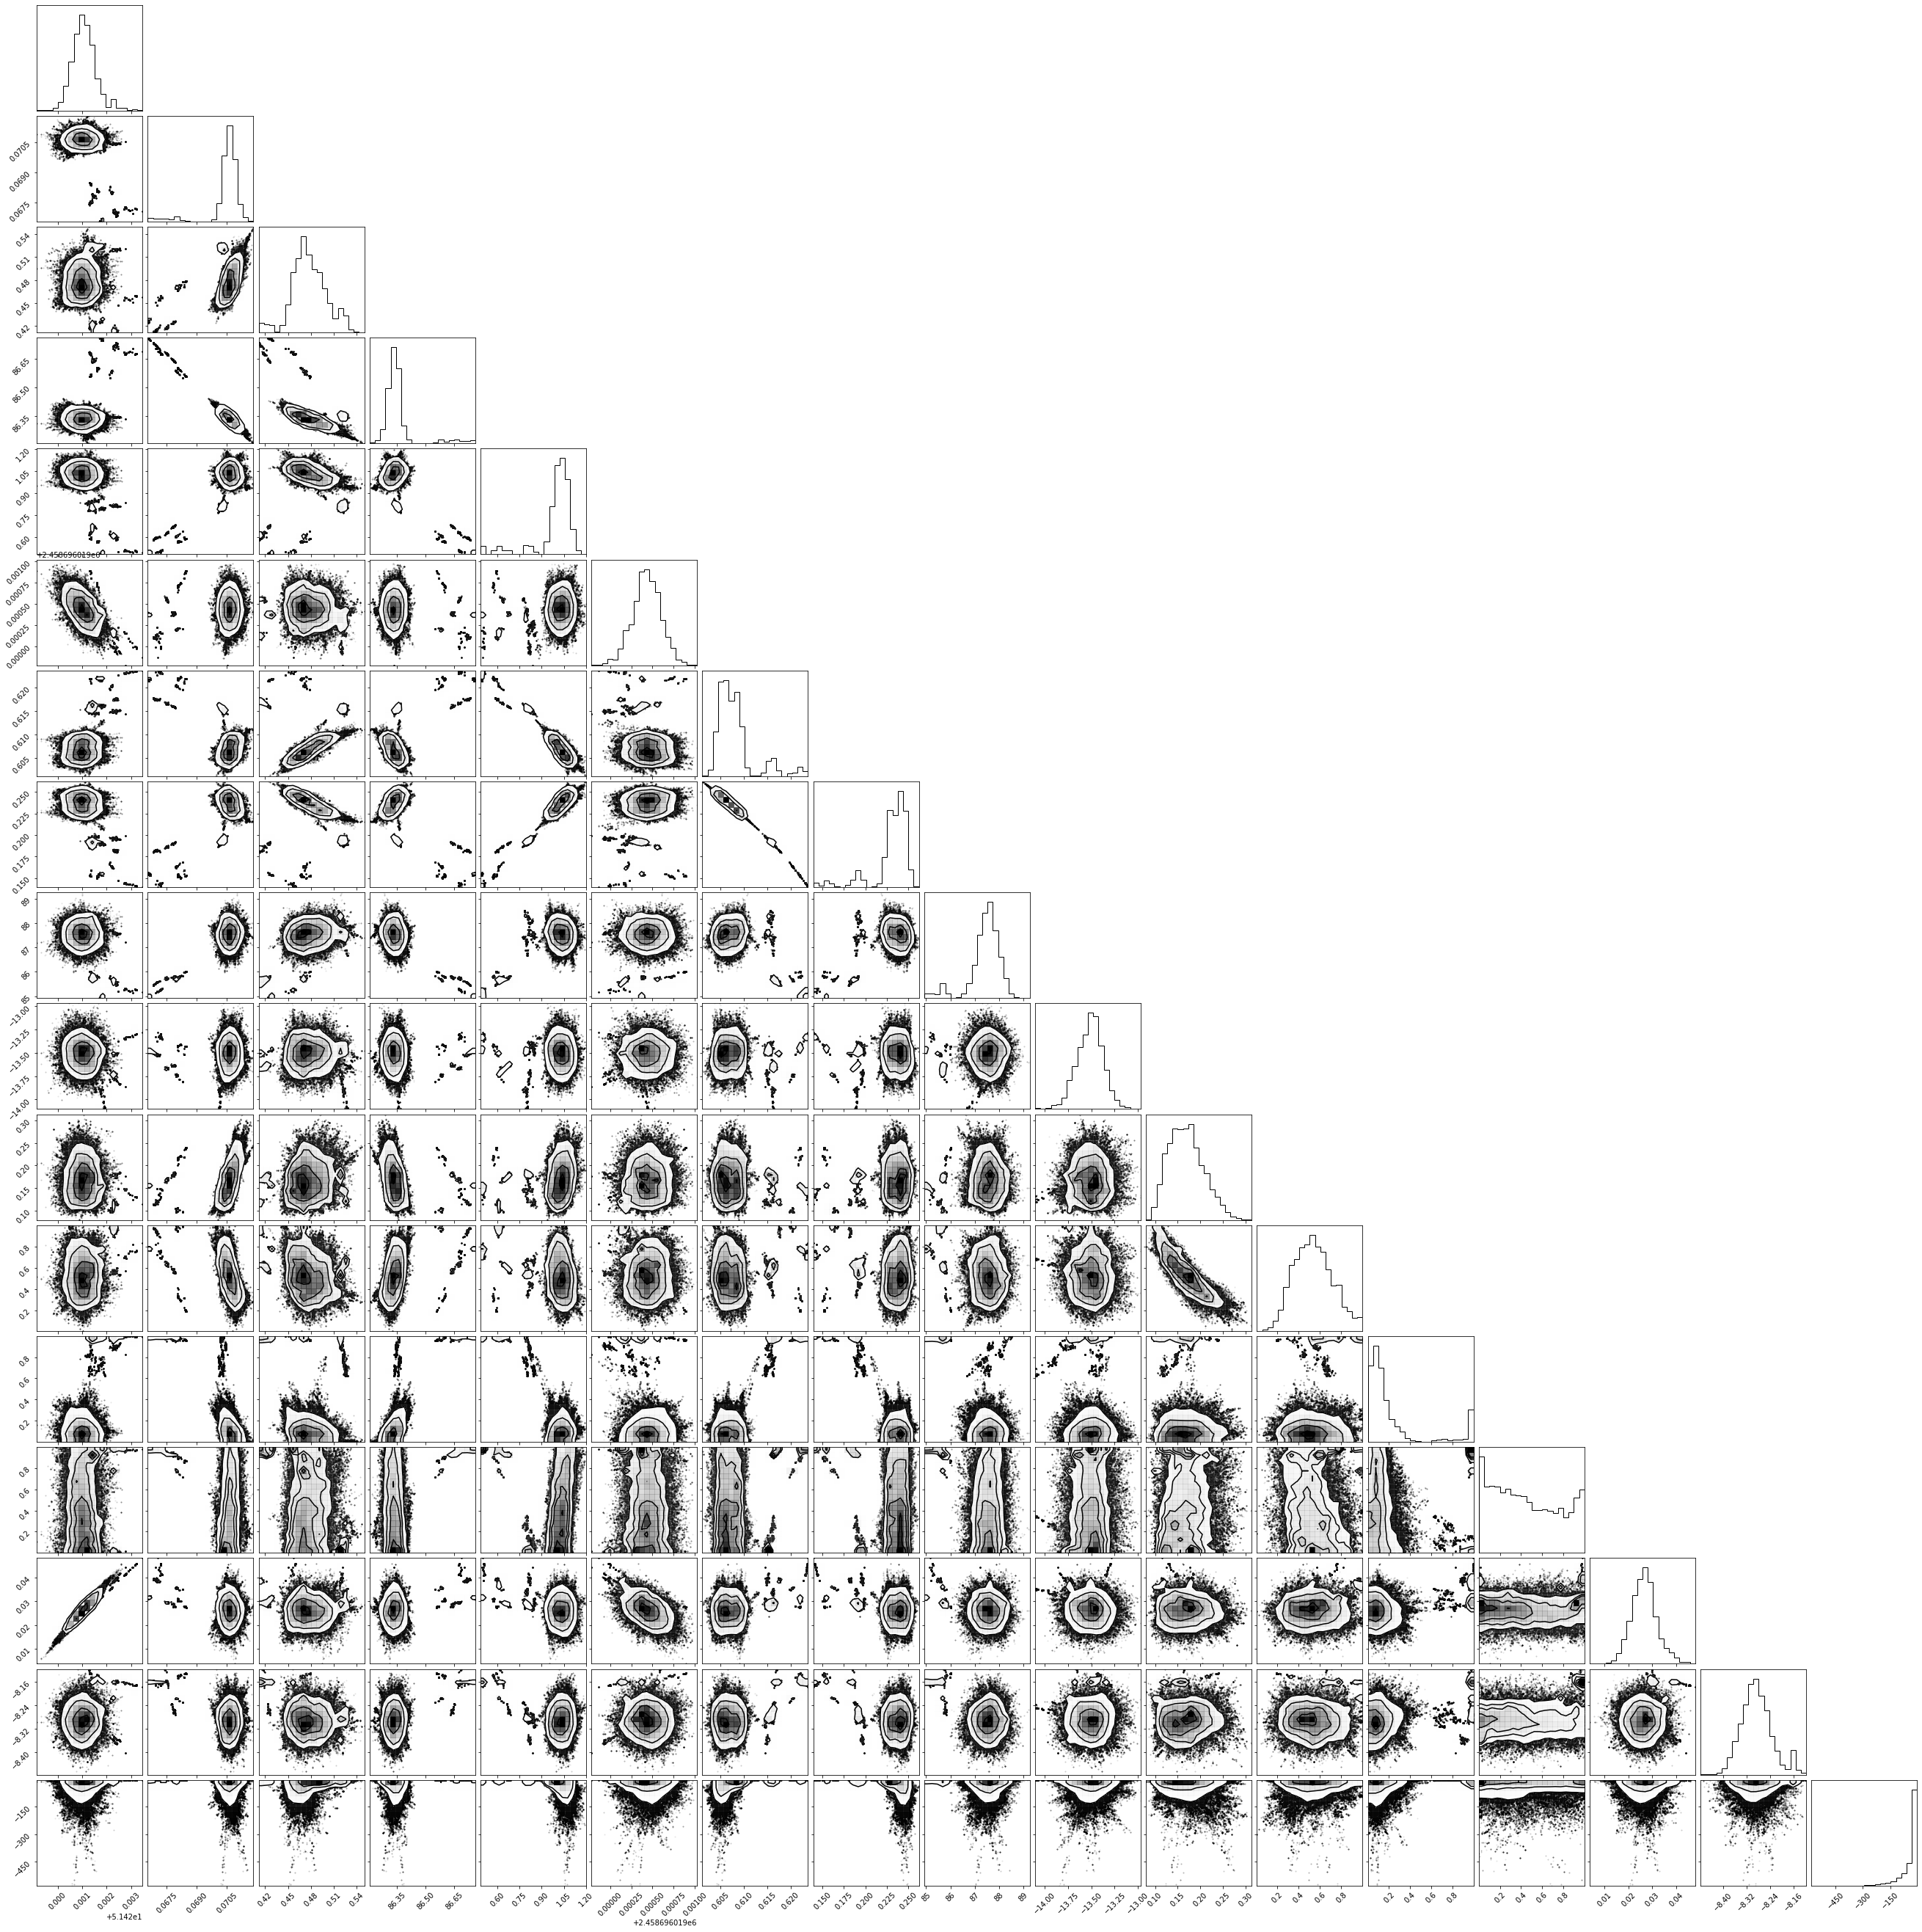

In [35]:
flat_samples = sampler.get_chain(discard=discard,flat=True)

import corner
# flat_samples = sampler.get_chain(flat=True)
#incl, r1, r2, sbratio, q
corner.corner(flat_samples, 
#               labels=['Period', '(R1+R2)/a', 'R2/R1', 'incl', 'sbratio', 't0', 'eccen', 'omega', 'ld11', 'ld12', 'ld21', 'ld22'], show_titles=True, smooth=0.3
             smooth=0.5);
# plt.savefig('ellc_fit.png', dpi=300)

In [53]:
names = ['period', 'rsum', 'rratio', 'incl', 'sbratio', 't0', 'f_c', 'f_s', 'mean', 'sma', 
         'gammav', 'q11', 'q12', 'q21', 'q22', 'domdt', 'didt']
for name, sample in zip(names, flat_samples.T):
    print(f'{name}: {np.mean(sample):.4f}\t+/-{np.std(sample):.4f}')

period: 51.4213	+/-0.0019
rsum: 0.0703	+/-0.0001
rratio: 0.4489	+/-0.0084
incl: 86.3789	+/-0.0134
sbratio: 1.0486	+/-0.0263
t0: 1696.0194	+/-0.0003
f_c: 0.6039	+/-0.0012
f_s: 0.2503	+/-0.0053
mean: -0.0003	+/-0.0000
sma: 87.4165	+/-0.3688
gammav: -13.5062	+/-0.1306
q11: 0.1317	+/-0.0112
q12: 0.8677	+/-0.0786
q21: 0.1322	+/-0.0429
q22: 0.1543	+/-0.1554
domdt: 0.0269	+/-0.0250
didt: -0.0000	+/-0.0000


In [124]:
import numpy as np
import astropy.units as u

asini = (np.exp(3.861042) * (u.km / u.s) * (51.472162 * u.day).to(u.s) * np.sqrt(1-0.426692**2) / (np.pi)).to(u.R_sun)
asini * np.sin(np.radians(86.3877))

<Quantity 87.26476481 solRad>

In [125]:
ellc.lc?

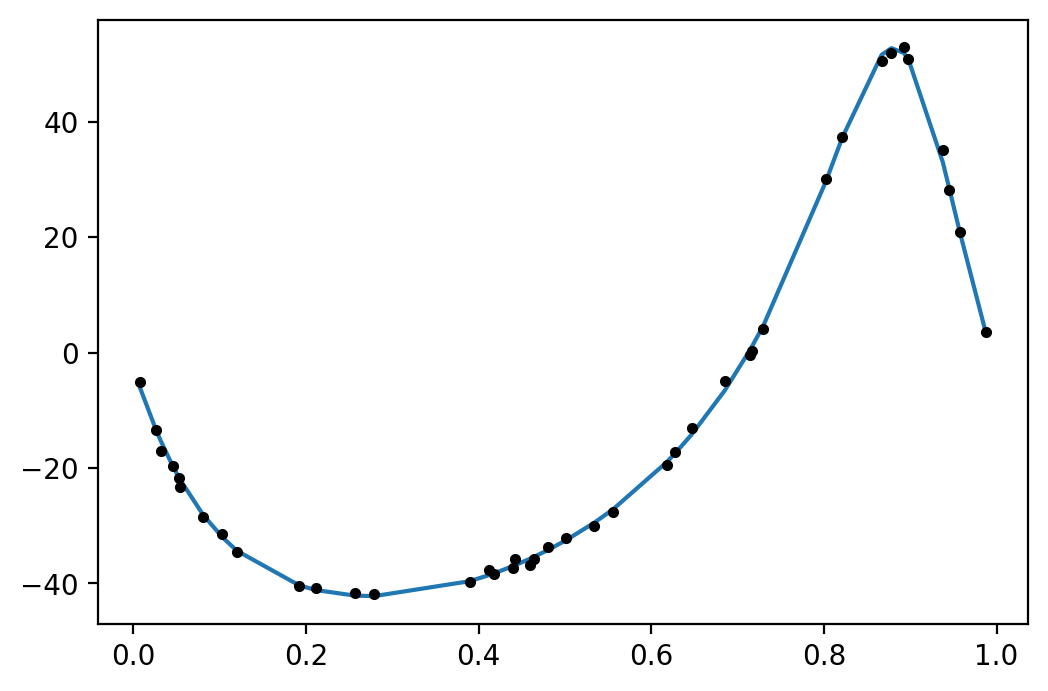

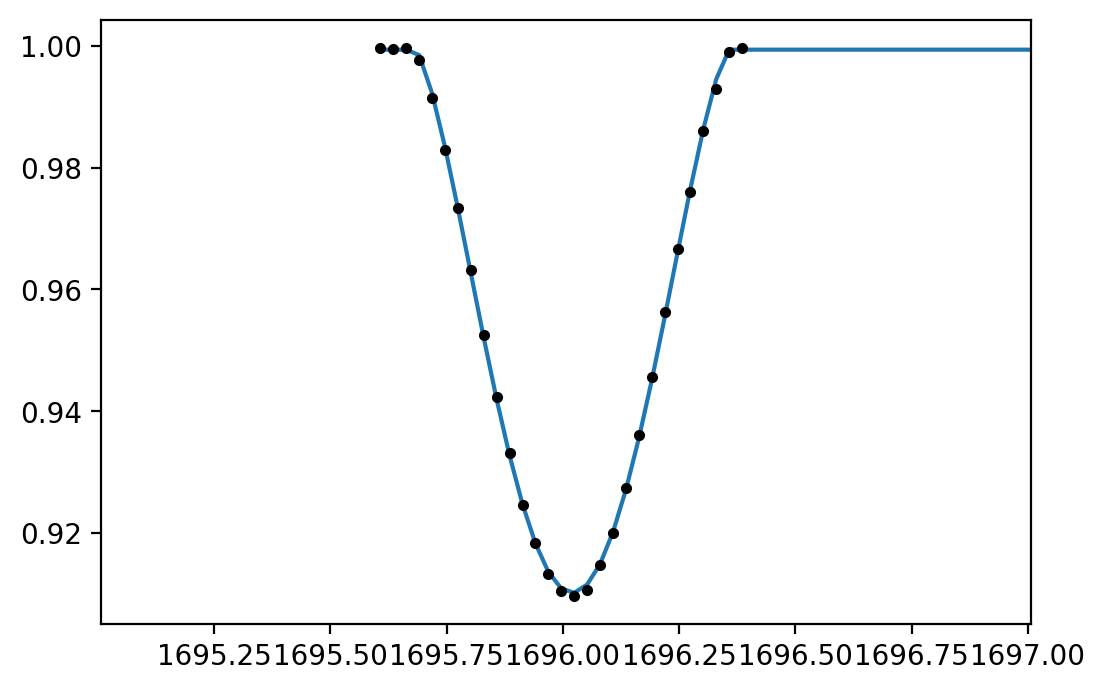

In [127]:
params = np.median(flat_samples, axis=0)
a = rv_model(params, rv_time)
fold = rv_time % 51.4192 / 51.4192
sort = np.argsort(fold)
plt.plot(fold[sort], a[sort])
plt.plot(fold[sort], rv_rv[sort], '.k')
plt.show()

b = lc_model(params, full_transit_time)
plt.plot(full_transit_time, b)
plt.plot(full_transit_time, full_transit_flux, '.k')
plt.xlim(t0_guess - 1, t0_guess+1)
plt.show()

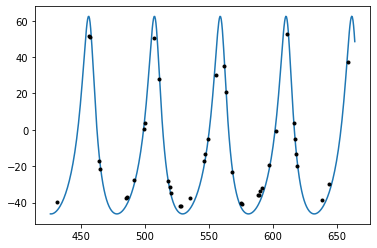

In [30]:
params = np.array([
    5.14192040e+01, # Period
    7.17949071e-02, # Rsum
    6.28722905e-01, # Rratio
    8.62150418e+01, # Incl
    6.91829286e-01, # Sbratio
    1.69601971e+03, # t0
    6.20730605e-01, # fc
    1.60481296e-01, # fs
    0., #logf
    0., #mean
    100, #sma
    -13.53 #gammav
])

period, rsum, rratio, incl, sbratio, t0, f_c, f_s, _, mean = params
r1, r2 = rsum/(1.+rratio), rsum*rratio/(1.+rratio)

    
fine_grid = np.linspace(rv_time.min()-5, rv_time.max()+5, 500)
rv = ellc.rv(fine_grid,t_zero=t0, #q=q,
            radius_1=0.01, radius_2=r2,a=101,
             incl=86,
#             ldc_2=[u21, u22],
             period=period, f_c=f_c, f_s=f_s)

# rv = gammav
plt.plot(fine_grid, rv[0] + gammav)
plt.plot(rv_time, rv_rv, '.k')

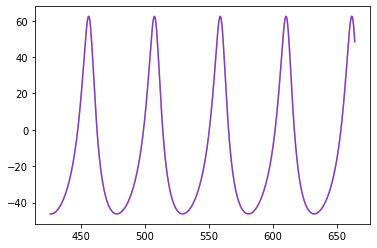

In [32]:
rv = ellc.rv(fine_grid,t_zero=t0, #q=q,
            radius_1=0.01, radius_2=r2,a=101,
             incl=86,
             period=period, f_c=f_c, f_s=f_s)
plt.plot(fine_grid, rv[0] + gammav, c='red', alpha=0.5)

rv = ellc.rv(fine_grid,t_zero=t0, #q=q,
            radius_1=0.05, radius_2=r2,a=101,
             incl=86,
             period=period, f_c=f_c, f_s=f_s)
plt.plot(fine_grid, rv[0] + gammav, c='blue', alpha=0.5)

In [34]:
import astropy.units as u
0.2031*u.AU.to(u.R_sun) / np.sin(np.radians(86))

43.77967590683847

In [117]:
ellc.lc?

In [129]:
8**(1/3)

2.0

In [ ]:
K = (2*pi*G)**(1/3) / np.sqrt(1-e**2) * (fm / Porb)**(1/3)


http://www.relativitycalculator.com/pdfs/RV_Derivation.pdf

https://iopscience.iop.org/article/10.3847/2515-5172/aac720

In [150]:
rsum = 0.17916
rratio = 1.1948

r1, r2 = rsum/(1.+rratio), rsum*rratio/(1.+rratio)
r1, r2


(0.08162930563149264, 0.0975306943685074)

In [180]:
K1 = 83.93
K2 = 78.42
P = 6.719695
e = 0.1771

In [181]:
import numpy as np
import astropy.units as u

aa = (K2 * (u.km / u.s) * (P * u.day).to(u.s) * np.sqrt(1-e**2) / 
     (2 * np.pi)).to(u.R_sun)# / (299792.458 * u.km / u.s)

bb = (K1 * (u.km / u.s) * (P * u.day).to(u.s) * np.sqrt(1-e**2) / 
     (2 * np.pi)).to(u.R_sun)# / (299792.458 * u.km / u.s)

In [182]:
aa, bb

(<Quantity 10.25105305 solRad>, <Quantity 10.97131959 solRad>)

In [183]:
r2 * aa * 2 / np.sin(np.radians(88.65))

<Quantity 0.43876744 solRad>

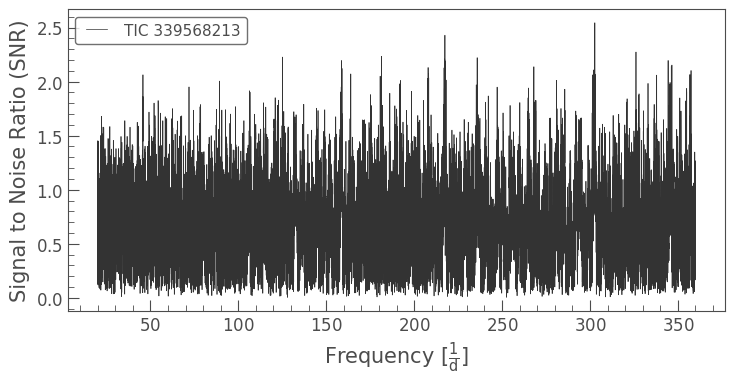

In [210]:
lc.to_periodogram(minimum_frequency=20).flatten().plot()